In [25]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


A1. Write a function to calculate the entropy associated with your dataset. (If your dataset contains
only continuous numeric data for outcome (a regression problem), employ equal width binning and
divide your data into 4 bins. Each bin may be considered as a categorical data value. Write a function
for equal width binning).

In [6]:

# Importing data
Data = pd.read_csv("/content/restaurant_reviews_anonymized.csv", encoding="latin1")

# Splitting data into fake and real classes
class_fake = Data[Data['Real'] == 0]
class_real = Data[Data['Real'] == 1]

def probability(Class, Data):
    return Class.shape[0] / Data.shape[0]

def entropy(Data, class1, class2):
    #Finding of probability
    class1_prob = probability(class1, Data)
    class2_prob = probability(class2, Data)

    entropy_value = 0
    for prob in [class1_prob, class2_prob]:
        if prob > 0:  # Avoid log2(0) error
            entropy_value -= prob * np.log2(prob)

    return entropy_value

print("The Entropy of the Dataset is:", entropy(Data, class_fake, class_real))


The Entropy of the Dataset is: 1.0


A2. Calculate the Gini index value for your dataset.

In [7]:
 #Gini Index for a binary classification dataset.
def gini_index(Data, class1, class2):
    #Finding the probability
    class1_prob = probability(class1, Data)
    class2_prob = probability(class2, Data)

    gini = 1 - (class1_prob**2 + class2_prob**2) #1-summation(p^2)
    return gini

gini_value = gini_index(Data, class_fake, class_real)
print("The Gini Index of the dataset is:", gini_value)

The Gini Index of the dataset is: 0.5



A3. Write your own module for detecting the feature / attribute for the root note of a Decision Tree.
Use Information gain as the impurity measure for identifying the root node. Assume that the
features are categorical or could be converted to categorical by binning.  


In [8]:
# Function to calculate entropy
def entropy(Data):
    classes = Data['Real'].value_counts(normalize=True)
    return -sum(classes * np.log2(classes))

# Function to calculate information gain for a feature
def information_gain(Data, feature):
    total_entropy = entropy(Data)  # Entropy of the entire dataset
    feature_values = Data[feature].unique()

    weighted_entropy = 0
    for value in feature_values:
        subset = Data[Data[feature] == value]
        subset_entropy = entropy(subset)
        weighted_entropy += (len(subset) / len(Data)) * subset_entropy

    return total_entropy - weighted_entropy

# Function to find the best feature for the root node
def find_root_node(Data):
    features = [col for col in Data.columns if col != 'Real']  # Exclude target column
    info_gains = {feature: information_gain(Data, feature) for feature in features}
    root_feature = max(info_gains, key=info_gains.get)  # Feature with highest IG
    return root_feature, info_gains[root_feature]

# Identify the root node
root_feature, max_ig = find_root_node(Data)
print(f"Best Root Node Feature: {root_feature} (Information Gain: {max_ig:.4f})")


Best Root Node Feature: Review (Information Gain: 1.0000)


A4. If the feature is continuous valued for A3, use equal width or frequency binning for converting
the attribute to categorical valued. The binning type should be a parameter to the function built for
binning. Write your own function for the binning task. The number of bins to be created should also
be passed as a parameter to the function. Use function overloading to allow for usage of default
parameters if no parameters are passed.

In [12]:
import numpy as np

def equal_width_binning(data, num_bins):
    min_val, max_val = np.min(data), np.max(data)
    bin_edges = np.linspace(min_val, max_val, num_bins + 1)  # Define bin edges
    bin_labels = np.digitize(data, bin_edges, right=False)  # Assign bin numbers
    return bin_labels

continuous_data = Data['F6-NWO'].to_numpy()  # Ensure it's a NumPy array
binned_data = equal_width_binning(continuous_data, 2)
print(binned_data)


[1 1 1 1 1 1 1 1 1 1 1 1 1 3 2 1 1 1 2 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1 1 2 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


A5. Expand the above functions to built your own Decision Tree module.





In [15]:
# Function to find the best feature for splitting
def find_best_split(Data):
    features = [col for col in Data.columns if col != 'Real']
    info_gains = {feature: information_gain(Data, feature) for feature in features}
    return max(info_gains, key=info_gains.get)

# Function to build the decision tree
def build_tree(Data, depth=0, max_depth=None):
    if len(Data['Real'].unique()) == 1 or (max_depth is not None and depth >= max_depth):
        return Counter(Data['Real']).most_common(1)[0][0]

    best_feature = find_best_split(Data)
    tree = {best_feature: {}}

    for value in Data[best_feature].unique():
        subset = Data[Data[best_feature] == value]
        tree[best_feature][value] = build_tree(subset, depth + 1, max_depth)

    return tree

# Function to predict class for a single sample
def predict_sample(tree, sample):
    if not isinstance(tree, dict):
        return tree
    feature = next(iter(tree))
    value = sample.get(feature, None)
    return predict_sample(tree[feature].get(value, Counter(Data['Real']).most_common(1)[0][0]), sample)

# Function to predict for all data points
def predict(Data, tree):
    return np.array([predict_sample(tree, row) for _, row in Data.iterrows()])

# Apply Equal Width Binning
Data['F6-NWO'] = equal_width_binning(Data['F6-NWO'].to_numpy(), num_bins=2)

# Build Decision Tree
decision_tree = build_tree(Data, max_depth=3)
print("Decision Tree Structure:", decision_tree)

# Make Predictions
predictions = predict(Data, decision_tree)
print("Predictions:", predictions)


Decision Tree Structure: {'Review': {'Great food and great atmosphere! The chicken tikka masala and garlic naan tasted as if they had come straight from India itself. Because I was so pleased with the entr\x8ee I ended \rup ordering the gulab jamun desert and mango lassi beverage and again I was nothing but pleased! Also the employees and management were all very attentive and they made\rsure we had everything we needed from beginning to end. The manager Matt personally came around even to check on our experience!': 0, 'I had heard good things about Rose Restaurant so I decided to go ahead and give the restaurant a try. The atmosphere was not what I was expecting. Walking through the front door it\rfelt as if it was a trying way too hard to be modern rather than Indian. The cashier took our orders and was polite, however, when I asked her to make my food mild she must not\rhave been listening. The food was brought out after waiting for 15 - 20 minutes and it was so spicy I could barely

A6. Draw and visualize the decision tree constructed based on your data. (Refer above provided web
sources [1] & [2] for understanding and learning on how to visualize a DT).




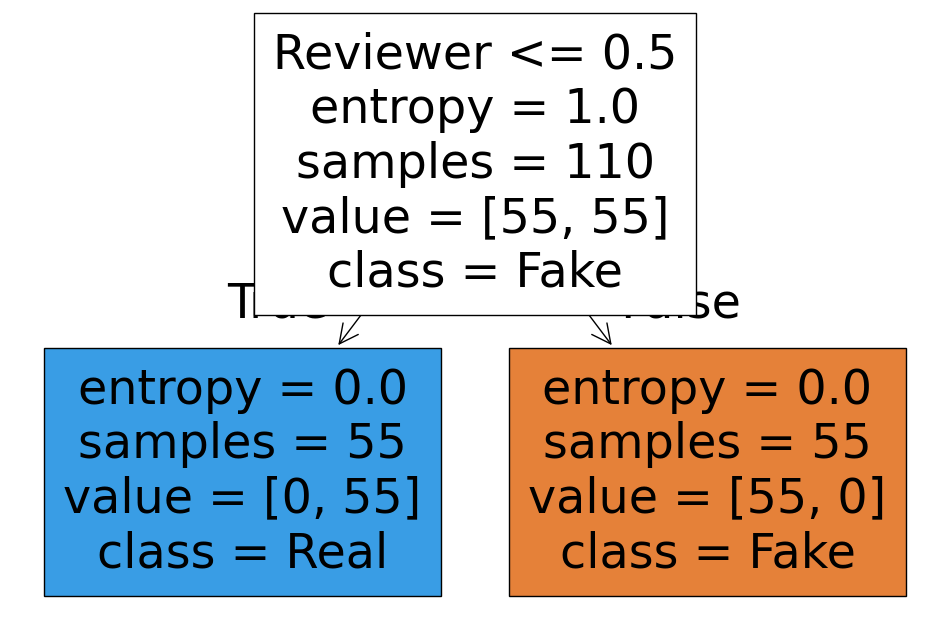

In [21]:
# Split Features and Target
X = Data.drop(columns=['Real','Restaurant','Review'])  # Features
y = Data['Real']  # Target

# Train Decision Tree
tree_model = DecisionTreeClassifier(criterion="entropy", max_depth=3)  # Using Entropy
tree_model.fit(X, y)

# Visualize Decision Tree
plt.figure(figsize=(12, 8))
plot_tree(tree_model, filled=True, feature_names=X.columns, class_names=["Fake", "Real"])
plt.show()


A7. Use 2 features from your dataset for a classification problem. Visualize the decision boundary
created by your DT in the vector space. (Refer above provided web source [3] & [2] for
understanding and learning on how to draw decision boundary for a DT).

> Add blockquote



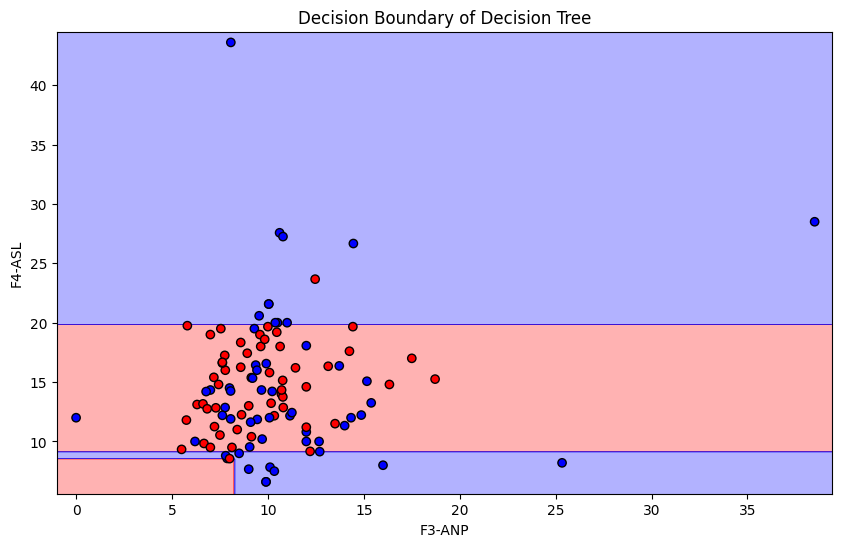

In [27]:
selected_features = ['F3-ANP', 'F4-ASL']  # Change features as needed

# Extract Features and Target
X = Data[selected_features].values
y = Data['Real'].values

# Function to train Decision Tree
def train_decision_tree(X, y, max_depth=3):
    tree_model = DecisionTreeClassifier(criterion="entropy", max_depth=max_depth)
    tree_model.fit(X, y)
    return tree_model

# Function to plot decision boundary
def plot_decision_boundary(tree_model, X, y, feature_names):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

    Z = tree_model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['red', 'blue']))
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=ListedColormap(['red', 'blue']))
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.title("Decision Boundary of Decision Tree")
    plt.show()

tree_model = train_decision_tree(X, y, max_depth=3)
plot_decision_boundary(tree_model, X, y, selected_features)


